In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil

# Path to the dataset
data_dir = '/content/drive/My Drive/RayosX'

# Subset directory
subset_dir = '/content/RayosX_subset'
os.makedirs(subset_dir, exist_ok=True)
os.makedirs(os.path.join(subset_dir, 'train', 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(subset_dir, 'train', 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(subset_dir, 'val', 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(subset_dir, 'val', 'PNEUMONIA'), exist_ok=True)

# Copy 50 images from each class
for category in ['NORMAL', 'PNEUMONIA']:
    train_files = os.listdir(os.path.join(data_dir, 'train', category))[:50]
    val_files = os.listdir(os.path.join(data_dir, 'test', category))[:50]

    for file in train_files:
        shutil.copy(os.path.join(data_dir, 'train', category, file), os.path.join(subset_dir, 'train', category))

    for file in val_files:
        shutil.copy(os.path.join(data_dir, 'test', category, file), os.path.join(subset_dir, 'val', category))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pip install tensorflow

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(subset_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(subset_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


###Muestra de una de las imagenes medicas

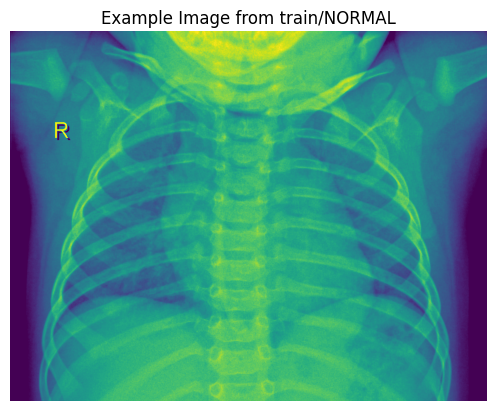

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

image_path = os.path.join(subset_dir, 'train', 'NORMAL', os.listdir(os.path.join(subset_dir, 'train', 'NORMAL'))[1])

# Load and display the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.title('Example Image from train/NORMAL')
plt.axis('off')  # Hide axis
plt.show()

##Entrenamiento de la red

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# Build the model with Transfer Learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Freeze the base model
base_model.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Unfreeze some layers in the base model and fine-tune
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model again
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Evaluate the model
_, acc = model.evaluate(val_generator, verbose=0)
print(f'Accuracy: {acc * 100:.2f}%')

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/20
3/3 [==============================] - 154s 61s/step - loss: 0.7397 - accuracy: 0.5208 - val_loss: 0.6849 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 130s 63s/step - loss: 0.8594 - accuracy: 0.3676 - val_loss: 0.6634 - val_accuracy: 0.5312
Epoch 3/20
3/3 [==============================] - 124s 46s/step - loss: 0.6834 - accuracy: 0.5882 - val_loss: 0.6553 - val_accuracy: 0.6042
Epoch 4/20
3/3 [==============================] - 129s 63s/step - loss: 0.7181 - accuracy: 0.5735 - val_loss: 0.6395 - val_accuracy: 0.8229
Epoch 5/20
3/3 [==============================] - 130s 54s/step - loss: 0.6141 - accuracy: 0.6354 - val_loss: 0.6365 - val_accuracy: 0.8125
Epoch 6/20
3/3 [==============================] - 131s 64s/step - loss: 0.7408 - accuracy: 0.5147 - val_loss: 0.6274 - val_accuracy: 0.8125
Epoch 7/20
3/3 [==============================] - 118s 56s/step - loss: 0.6476 - accuracy: 0.63

###Evaluación del modelo sin el modelo base

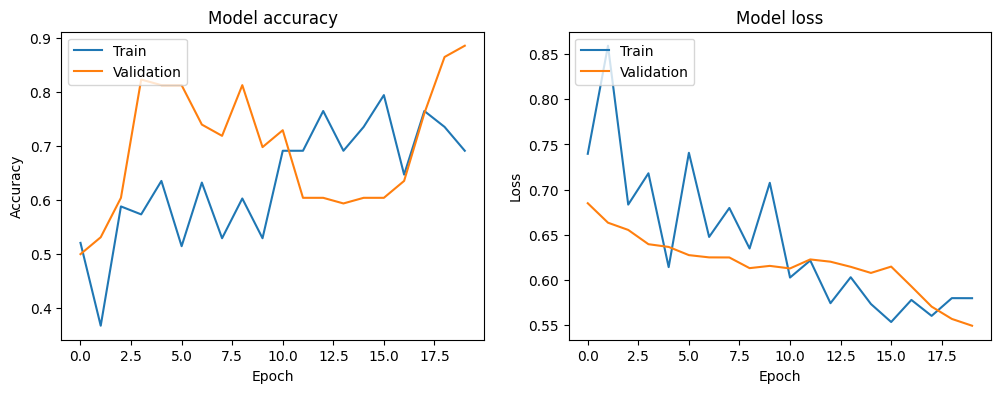

In [8]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()



###Evaluacion con el modelo base

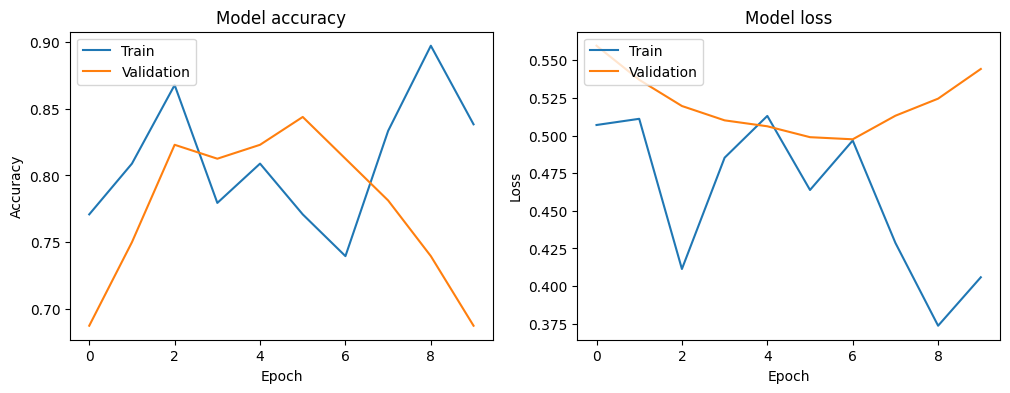

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train')
plt.plot(history_fine.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train')
plt.plot(history_fine.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

Si bien no es un modelo tan malo, puede mejorar. Según se observa en la gráfica, se tiene ciertos valores similares. Para mejorar la precisión y que no esté tan overfiteado, se debería utilizar otra aproximación, quizá usar el método de gradientes para el error, o añadir alguna capa u otro tipo de función de activación.

Asimismo, una limitante de toda red convolucional es la cantidad de data que se necesita para esta. Sería bueno probar con más data.